In [46]:
# a first look at the data
head(data)
summary(data)

,X,ID,TreatmentGroup,Age,Sex,ECOG_PS,GFR,Time,Event
,<int>,<int>,<chr>,<int>,<chr>,<int>,<int>,<dbl>,<int>
1,1,1,Treatment,73,Female,2,83,0.6,1
2,2,2,Treatment,62,Male,0,86,6.3,1
3,3,3,Treatment,61,Female,0,98,57.7,0
4,4,4,Treatment,66,Male,1,58,0.7,1
5,5,5,Treatment,88,Female,0,120,30.7,0
6,6,6,Treatment,73,Male,0,55,6.5,1


       X                ID         TreatmentGroup          Age      
 Min.   :  1.00   Min.   :  1.00   Length:300         Min.   :38.0  
 1st Qu.: 75.75   1st Qu.: 75.75   Class :character   1st Qu.:59.0  
 Median :150.50   Median :150.50   Mode  :character   Median :65.0  
 Mean   :150.50   Mean   :150.50                      Mean   :65.3  
 3rd Qu.:225.25   3rd Qu.:225.25                      3rd Qu.:72.0  
 Max.   :300.00   Max.   :300.00                      Max.   :91.0  
     Sex               ECOG_PS            GFR              Time       
 Length:300         Min.   :0.0000   Min.   : 30.00   Min.   : 0.000  
 Class :character   1st Qu.:0.0000   1st Qu.: 66.00   1st Qu.: 2.600  
 Mode  :character   Median :1.0000   Median : 81.00   Median : 5.900  
                    Mean   :0.8167   Mean   : 78.89   Mean   : 9.673  
                    3rd Qu.:1.0000   3rd Qu.: 91.00   3rd Qu.:13.600  
                    Max.   :2.0000   Max.   :120.00   Max.   :57.700  
     Event     
 Min

From the visual graphs we can observe quite a even split between the control and treatment group, further more the number of male are more in number making the data is skewed. For GFR, Age the data distribution look quite normal but time distribution is heavily left skewed.

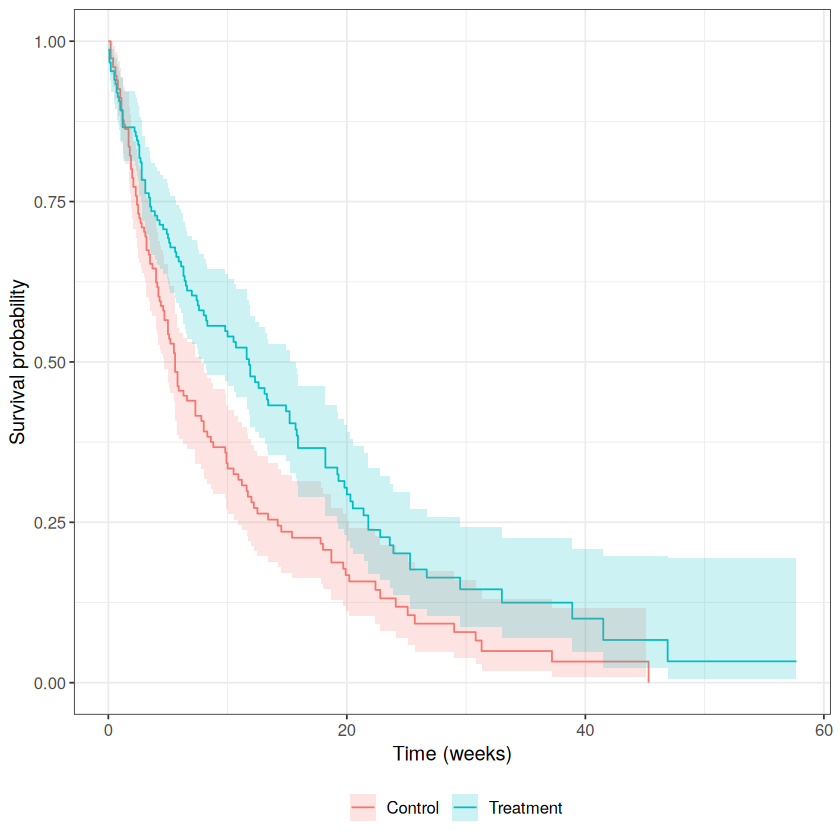

In [57]:
# Kaplan-Meier survival curves with confidence intervals by treatment group
survfit2(Surv(Time, Event) ~ TreatmentGroup, data = data) |> 
  ggsurvfit() +
  labs(
    x = "Time (weeks)",
    y = "Survival probability"
  )+ 
  add_confidence_interval() #+
  # add_risktable()

In [68]:
summary(survfit2(Surv(Time, Event) ~ TreatmentGroup, data = data), times = 5)


Call: survfit(formula = Surv(Time, Event) ~ TreatmentGroup, data = data)

                TreatmentGroup=Control 
        time       n.risk      n.event     survival      std.err lower 95% CI 
       5.000       77.000       65.000        0.543        0.042        0.467 
upper 95% CI 
       0.632 

                TreatmentGroup=Treatment 
        time       n.risk      n.event     survival      std.err lower 95% CI 
      5.0000      99.0000      45.0000       0.6927       0.0382       0.6217 
upper 95% CI 
      0.7718 


*We are using Kaplan-Meier survival modeling here, a thing to observer here the early treatment for first 4 weeks we can see the control group having better survival odds but with increasing time the treatment shows effect and we can see uplift of the treatment course.*

Can be observed in the graphs.

In [53]:
# Fit the Cox PH model
cox_model <- coxph(Surv(Time, Event) ~ TreatmentGroup + Age + Sex + ECOG_PS + GFR, data = data)

# Summarize the model
summary(cox_model)


Call:
coxph(formula = Surv(Time, Event) ~ TreatmentGroup + Age + Sex + 
    ECOG_PS + GFR, data = data)

  n= 300, number of events= 228 

                             coef exp(coef)  se(coef)      z Pr(>|z|)    
TreatmentGroupTreatment -0.525216  0.591428  0.138716 -3.786 0.000153 ***
Age                     -0.010326  0.989727  0.006697 -1.542 0.123080    
SexMale                 -0.086113  0.917490  0.137160 -0.628 0.530115    
ECOG_PS                  0.444375  1.559514  0.091175  4.874 1.09e-06 ***
GFR                     -0.013653  0.986439  0.003674 -3.716 0.000202 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                        exp(coef) exp(-coef) lower .95 upper .95
TreatmentGroupTreatment    0.5914     1.6908    0.4506    0.7762
Age                        0.9897     1.0104    0.9768    1.0028
SexMale                    0.9175     1.0899    0.7012    1.2005
ECOG_PS                    1.5595     0.6412    1.3043    1.8647
GFR                     

Key observations:
After analy the Pr(>|z|), we find 3 factors to be significant - TreatmentGroup, ECOG_PS & GFR
* TreatmentGroup = Treatment, P value is quite small and we can see there is a negative coefficient meaning there is an inverse correlation to the risk of death, meaning the person having the treatment has a higher chance of recovery and by exp(coef) reduces it by 41%
* ECOG_PS, p value is quite small and is significant furthermore it has a positive correlation and by looking the exp(coef) we can can it increases the chance of death.
* GFR, is relevant due to the small p value, and has as negative relation i.e. 1 unit increase in GFR adds decreased risk by 1.4%.

In [55]:
# Extract the hazard ratios and 95% CI
hazard_ratios <- coef(cox_model)
conf_int <- confint(cox_model)

# Print the results
print(paste("Hazard Ratios and 95% CI:"))
print(hazard_ratios)
print(conf_int)


[1] "Hazard Ratios and 95% CI:"
TreatmentGroupTreatment                     Age                 SexMale 
            -0.52521603             -0.01032611             -0.08611317 
                ECOG_PS                     GFR 
             0.44437455             -0.01365335 
                              2.5 %       97.5 %
TreatmentGroupTreatment -0.79709423 -0.253337834
Age                     -0.02345135  0.002799134
SexMale                 -0.35494193  0.182715596
ECOG_PS                  0.26567435  0.623074745
GFR                     -0.02085457 -0.006452126


Looking at the HR ratios of the Cox PH model, we draw similar conclusions as before. 
Furthermore there are some slightly significant observations that can be drawn are being Male reduced the risk marginally or with age the risk goes down as well.
But looking at the data imbalance we can see the data to be favoring men as well as higher ages.